## 3. Risk Management

### 3.1 Fraud Detection
Data Source: https://www.kaggle.com/datasets/neharoychoudhury/credit-card-fraud-data/data

AI Branches: ML & DL & NLP

Models: Random Forest Classifier (RFC) & Fully Connected Neural Network (FCNN)

Methods: Binary Classification

Data Field Description
This dataset contains information on credit card transactions, including labeled fraudulent transactions (is_fraud). Below is a detailed description of each data field:


trans_date_trans_time: The date and time when the transaction occurred.

merchant: The name of the merchant where the transaction took place.

category: The category of the merchant, such as dining, retail, etc.

amt: The amount of the transaction.

city: The city where the credit card holder resides.

state: The state where the credit card holder resides.

lat: The latitude location of the credit card holder.

long: The longitude location of the credit card holder.

city_pop: The population of the city where the credit card holder resides.

job: The occupation of the credit card holder.

dob: The date of birth of the credit card holder.

trans_num: A unique identifier for each transaction.

merch_lat: The latitude location of the merchant.

merch_long: The longitude location of the merchant.

is_fraud: Indicates whether the transaction is fraudulent (1) or not (0).

This dataset is useful for credit card fraud detection tasks, where the goal is to build machine learning or deep learning models to predict whether a given transaction is fraudulent.

In [5]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import pandas as pd
import re
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE # Import SMOTE


warnings.filterwarnings("ignore")

# ----------------------------------------------------------------------------
# 1. Data Loading and Initial Exploration (unchanged)
# ----------------------------------------------------------------------------

# Load the data
df = pd.read_csv("fraud_data.csv")

# Display initial information
print("DataFrame Head:\n", df.head(), "\n")
print("DataFrame Info:")
df.info()
print("\nDataFrame Description:\n", df.describe(), "\n")

# Check for missing values
missing_values = df.isnull().sum()
print("Missing Values:\n", missing_values[missing_values > 0], "\n")

# ----------------------------------------------------------------------------
# 2. Data Cleaning and Feature Engineering (unchanged)
# ----------------------------------------------------------------------------

# Define functions for cleaning and parsing
def clean_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'[^a-z\s]', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
    return text

def parse_trans_date(date_str):
    try:
        return pd.to_datetime(date_str, format='%d-%m-%Y %H:%M')
    except ValueError:
        return pd.NaT

def parse_dob(dob_str):
    try:
        return pd.to_datetime(dob_str, format='%d-%m-%Y')
    except ValueError:
        return pd.NaT

# Apply cleaning and parsing
df['merchant'] = df['merchant'].apply(clean_text)
df['job'] = df['job'].apply(clean_text)
df['category'] = df['category'].apply(clean_text)
df['trans_date_trans_time'] = df['trans_date_trans_time'].apply(parse_trans_date)
df['dob'] = df['dob'].apply(parse_dob)

# Create new features
df['age'] = df['trans_date_trans_time'].dt.year - df['dob'].dt.year
df['transaction_hour'] = df['trans_date_trans_time'].dt.hour
df['trans_date'] = pd.to_datetime(df['trans_date_trans_time'].dt.date)

# Handle 'is_fraud' column
df['is_fraud'] = pd.to_numeric(df['is_fraud'].astype(str).str.replace('"', '').str.strip(), errors='coerce')
df = df[df['is_fraud'].isin([0, 1])]
df['is_fraud'] = df['is_fraud'].astype(int)

# Create a copy for the model (leaving the original df for the widget)
df_model = df.copy()

# Display updated info
print("Updated DataFrame:")
print("\nUpdated DataFrame Info:")
df_model.info()
print("\nUpdated DataFrame Description:")
print(df_model.describe(), "\n")

# Check for missing values again
missing_values_updated = df_model.isnull().sum()
print("Updated Missing Values:")
print(missing_values_updated[missing_values_updated > 0], "\n")

df.head()

DataFrame Head:
   trans_date_trans_time                          merchant        category  \
0      04-01-2019 00:58  "Stokes, Christiansen and Sipes"     grocery_net   
1      04-01-2019 15:06                      Predovic Inc    shopping_net   
2      04-01-2019 22:37                   Wisozk and Sons        misc_pos   
3      04-01-2019 23:06                    Murray-Smitham     grocery_pos   
4      04-01-2019 23:59                        Friesen Lt  health_fitness   

      amt   city state      lat      long  city_pop  \
0   14.37  Wales    AK  64.7556 -165.6723       145   
1  966.11  Wales    AK  64.7556 -165.6723       145   
2   49.61  Wales    AK  64.7556 -165.6723       145   
3  295.26  Wales    AK  64.7556 -165.6723       145   
4   18.17  Wales    AK  64.7556 -165.6723       145   

                          job         dob                         trans_num  \
0  "Administrator, education"  09-11-1939  a3806e984cec6ac0096d8184c64ad3a1   
1  "Administrator, education"  

,trans_date_trans_time,merchant,category,amt,city,state,lat,long,city_pop,job,dob,trans_num,merch_lat,merch_long,is_fraud,age,transaction_hour,trans_date
0,2019-01-04 00:58:00,stokes christiansen and sipes,grocerynet,14.37,Wales,AK,64.7556,-165.6723,145,administrator education,1939-11-09,a3806e984cec6ac0096d8184c64ad3a1,65.654142,-164.722603,1,80,0,2019-01-04
1,2019-01-04 15:06:00,predovic inc,shoppingnet,966.11,Wales,AK,64.7556,-165.6723,145,administrator education,1939-11-09,a59185fe1b9ccf21323f581d7477573f,65.468863,-165.473127,1,80,15,2019-01-04
2,2019-01-04 22:37:00,wisozk and sons,miscpos,49.61,Wales,AK,64.7556,-165.6723,145,administrator education,1939-11-09,86ba3a888b42cd3925881fa34177b4e0,65.347667,-165.914542,1,80,22,2019-01-04
3,2019-01-04 23:06:00,murraysmitham,grocerypos,295.26,Wales,AK,64.7556,-165.6723,145,administrator education,1939-11-09,3a068fe1d856f0ecedbed33e4b5f4496,64.445035,-166.080207,1,80,23,2019-01-04
4,2019-01-04 23:59:00,friesen lt,healthfitness,18.17,Wales,AK,64.7556,-165.6723,145,administrator education,1939-11-09,891cdd1191028759dc20dc224347a0ff,65.447094,-165.446843,1,80,23,2019-01-04


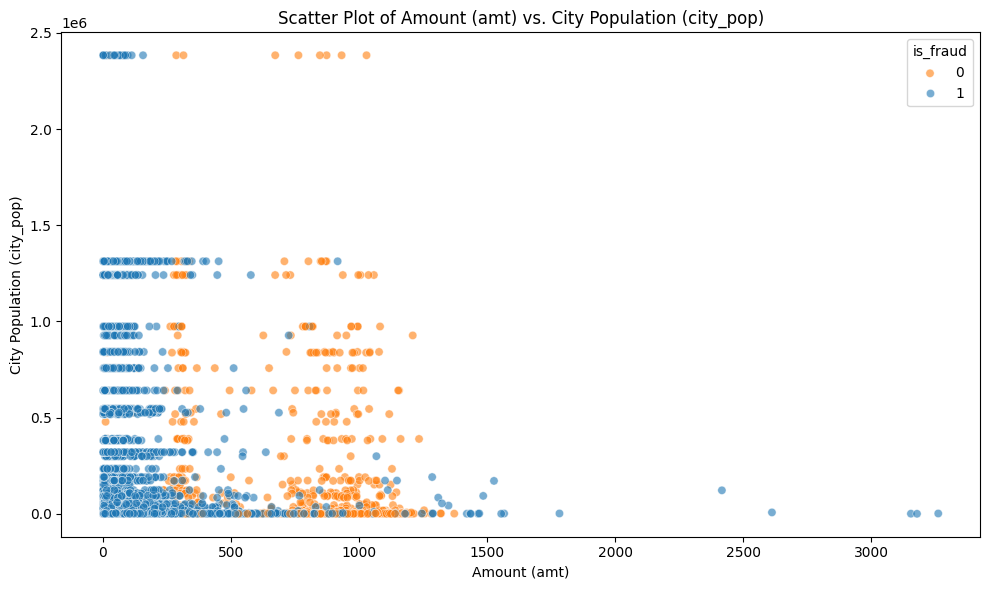

In [6]:
# ----------------------------------------------------------------------------
# 3. Exploratory Data Analysis (EDA) Visualizations
# ----------------------------------------------------------------------------

#Create a copy for visualizations
df_eda = df.copy()

# Fraud proportion by city (Map)
city_fraud_counts = df_eda.groupby('city')['is_fraud'].agg(['count', 'sum']).reset_index()
city_fraud_counts['fraud_proportion'] = (city_fraud_counts['sum'] / city_fraud_counts['count']) * 100

city_lat_long = df_eda[['city', 'lat', 'long']].drop_duplicates()
city_fraud_counts = city_fraud_counts.merge(city_lat_long, on='city')

fig = px.scatter_mapbox(
    city_fraud_counts,
    lat='lat',
    lon='long',
    size='fraud_proportion',
    color='fraud_proportion',
    color_continuous_scale=px.colors.sequential.Plasma,
    hover_name='city',
    size_max=30,
    title='Fraud Proportion Density by City',
)

fig.update_layout(mapbox_style="open-street-map", mapbox_zoom=3, mapbox_center={"lat": df_eda['lat'].mean(), "lon": df_eda['long'].mean()})
fig.show()

# Visualize fraud by Age and Transaction Hour
def plot_fraud_by(df_eda, category, title, x_title, y2_title):
    fraud_df = df_eda[df_eda['is_fraud'] == 1]

    total_counts = df_eda[category].value_counts().sort_index()
    fraud_counts = fraud_df[category].value_counts().sort_index()
    fraud_proportion = (fraud_counts / total_counts).fillna(0) * 100

    fig = make_subplots(specs=[[{"secondary_y": True}]])
    colors = ['blue', 'green', 'orange', 'red', 'purple', 'brown', 'pink']

    for val in fraud_df[category].unique():
        color = colors[val // 10 if category == 'age' else val] if (val // 10 if category == 'age' else val) < len(colors) else 'black'
        fig.add_trace(go.Scatter(
            x=fraud_df[fraud_df[category] == val][category],
            y=fraud_df[fraud_df[category] == val]['trans_date_trans_time'],
            mode='markers',
            marker=dict(color=color, opacity=0.6),
            name=f'{category} {val}',
            showlegend=False
        ), secondary_y=False)

    fig.add_trace(go.Scatter(
        x=fraud_proportion.index,
        y=fraud_proportion.values,
        mode='lines+markers',
        name='Fraud Proportion (%)',
        line=dict(color='green'),
        marker=dict(symbol='circle')
    ), secondary_y=True)

    fig.update_layout(
        title=title,
        xaxis_title=x_title,
        yaxis_title='Transaction Date',
        yaxis2_title=y2_title,
        title_font_size=20,
        legend=dict(x=0, y=1, traceorder='normal', bgcolor='rgba(255, 255, 255, 0.5)')
    )
    fig.update_yaxes(title_text='Transaction Date', secondary_y=False)
    fig.update_yaxes(title_text=y2_title, secondary_y=True, range=[0, 100])

    fig.show()

plot_fraud_by(df_eda.copy(), 'age', 'Fraud Transaction by Age', 'Age', 'Fraud Proportion (%)')
plot_fraud_by(df_eda.copy(), 'transaction_hour', 'Fraud Transaction by Hour', 'Transaction Hour', 'Fraud Proportion (%)')

# Visualize fraud by Job and Category
def plot_fraud_bar(df_eda, category, title, x_title, y2_title):
    fraud_df = df_eda[df_eda['is_fraud'] == 1]

    total_counts = df_eda[category].value_counts()
    fraud_counts = fraud_df[category].value_counts()
    fraud_proportion = (fraud_counts / total_counts).fillna(0) * 100

    fig = make_subplots(specs=[[{"secondary_y": True}]])

    fig.add_trace(go.Bar(
        x=fraud_proportion.index.astype(str),
        y=fraud_proportion.values,
        name='Fraud Proportion (%)',
        marker_color='green',
        opacity=0.7
    ), secondary_y=True)

    fig.add_trace(go.Scatter(
        x=total_counts.index.astype(str),
        y=total_counts.values,
        mode='markers',
        name='Total Count',
        marker=dict(color='orange', opacity=0.6
        )
    ), secondary_y=False)

    fig.update_layout(
        title=title,
        xaxis_title=x_title,
        yaxis_title='Total Count',
        yaxis2_title=y2_title,
        title_font_size=20,
        legend=dict(x=0, y=1, traceorder='normal', bgcolor='rgba(255, 255, 255, 0.5)')
    )
    fig.update_yaxes(title_text='Total Count', secondary_y=False)
    fig.update_yaxes(title_text=y2_title, secondary_y=True, range=[0, 100])

    fig.show()

plot_fraud_bar(df_eda.copy(), 'job', 'Fraud Proportion by Job', 'Job', 'Fraud Proportion (%)')
plot_fraud_bar(df_eda.copy(), 'category', 'Fraud Proportion by Category', 'Category', 'Fraud Proportion (%)')

# Visualize Amount vs. City Population
num_cols = df_eda.select_dtypes(include=[np.number]).columns
cat_cols = df_eda.select_dtypes(include=['object']).columns
for col in cat_cols:
    df_eda[col].fillna(df_eda[col].mode()[0], inplace=True)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_eda, x='amt', y='city_pop', hue='is_fraud', alpha=0.6)
plt.title('Scatter Plot of Amount (amt) vs. City Population (city_pop)')
plt.xlabel('Amount (amt)')
plt.ylabel('City Population (city_pop)')
plt.legend(title='is_fraud', labels=['0', '1'])
plt.tight_layout()
plt.show()

In [7]:
import spacy
import pandas as pd
from spacy.matcher import PhraseMatcher

# 加载 spaCy 模型
nlp = spacy.load("en_core_web_sm")

# 假设 df_eda 已经存在并包含 'merchant' 和 'is_fraud' 列

# 1. 创建 PhraseMatcher
matcher = PhraseMatcher(nlp.vocab, attr="LOWER")  # 使用 LOWER 属性进行不区分大小写的匹配

# 2. 构建已知商家列表（从数据中提取并精简）
#    这里使用了 set 来进行高效的去重
known_merchants = list(set([merchant for merchant in df_eda['merchant'].str.lower().unique() if isinstance(merchant, str)]))  # 确保merchant是字符串,然后去重和小写
patterns = [nlp(name) for name in known_merchants]
matcher.add("KNOWN_MERCHANTS", patterns)

# 3. 标准化函数
def standardize_merchant(text):
    if isinstance(text, str):
        doc = nlp(text)
        matches = matcher(doc)
        if matches:
            _, start, end = matches[0]  # 取第一个匹配项
            return doc[start:end].text  # 返回标准化的名称
    return text  # 如果没有匹配，返回原文本（已经 clean_text 处理过）

# 4. 应用标准化
df_eda['merchant_standardized'] = df_eda['merchant'].apply(standardize_merchant)

# 5. 计算欺诈统计
merchant_stats = df_eda.groupby('merchant_standardized')['is_fraud'].agg(['count', 'sum', 'mean']).reset_index()
merchant_stats.columns = ['merchant', 'total_transactions', 'fraud_transactions', 'fraud_ratio']
merchant_stats = merchant_stats.sort_values(by='fraud_ratio', ascending=False)

print(merchant_stats.head(20)) #显示前20

                                merchant  total_transactions  \
80                             brown plc                  10   
510                           rempel inc                  23   
352                            kunze inc                  31   
304                       kerlukeabshire                  35   
158                     emmerichluettgen                   4   
527  romaguera cruickshank and greenholt                  37   
309                        kiehnemmerich                  42   
434              moore dibbert and koepp                  17   
616                            terryhuel                  30   
342                          krisweimann                  13   
622          tillman fritsch and schmitt                  22   
661                            welch inc                  18   
337                           kozeyboehm                  21   
647                           volkman lt                  12   
201                          goyette inc

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best Parameters: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

Random Forest Metrics:
   Accuracy  Precision    Recall  F1-Score
0  0.971616   0.973564  0.971616  0.972233


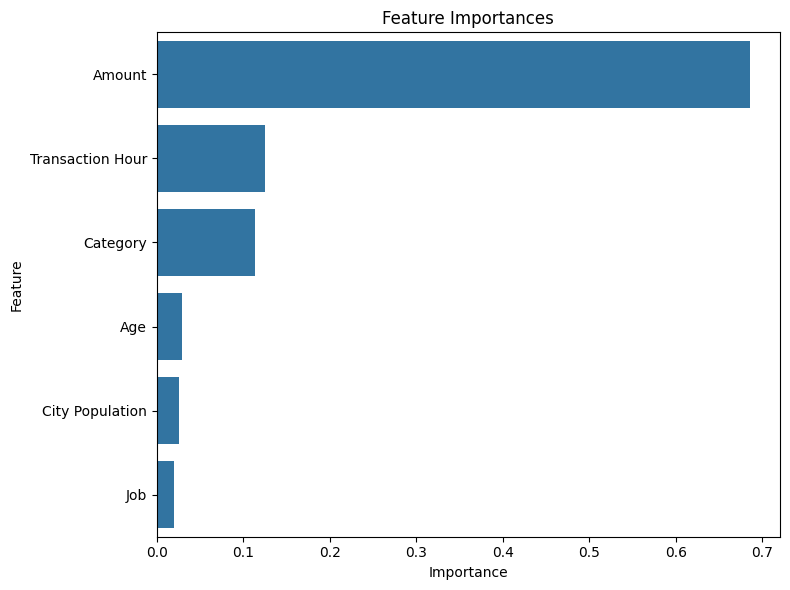

,Sample,Category,Amount,City Population,Job,Age,Transaction Hour,Prediction,Probability of Fraud
0,Sample 1,12,122.000000,1302,78,43,0,0,0.010083
1,Sample 2,0,500.000000,1000000,1,45,18,1,0.876862
2,Sample 3,1,300.000000,7500,1,30,7,1,0.782753


In [8]:
# ----------------------------------------------------------------------------
# 4. Feature Engineering, Encoding, and Data Splitting (for ML)
# ----------------------------------------------------------------------------
df_model = df.copy()

# Define Features and Target (for the model)
features = ['category', 'amt', 'city_pop', 'job', 'age', 'transaction_hour']
target = 'is_fraud'

# Define Feature Datatypes
feature_dtypes = {'category': 'str', 'job': 'str', 'amt': 'float64', 'city_pop': 'int64', 'age': 'int64', 'transaction_hour': 'int64'}
for feature, dtype in feature_dtypes.items():
    df_model[feature] = df_model[feature].astype(dtype)

# Encode categorical variables (Label Encoding)
categorical_columns = ['category', 'job']
label_encoders = {col: LabelEncoder().fit(df_model[col]) for col in categorical_columns}
for col in categorical_columns:
    df_model[col] = label_encoders[col].transform(df_model[col])

# Split Data & Handle Imbalance (with Stratification)
X = df_model[features]
y = df_model[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7, stratify=y)

# Handle Imbalance (SMOTE)
from imblearn.over_sampling import SMOTE # Import SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# ----------------------------------------------------------------------------
# 5. Model Training and Evaluation (Random Forest)
# ----------------------------------------------------------------------------

# Define Parameter Grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Random Forest Model & GridSearchCV
rf = RandomForestClassifier(random_state=7)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Get Best Estimator and Parameters
best_rf = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Make Predictions
y_pred_rf = best_rf.predict(X_test)

# Evaluate Model
report_rf = classification_report(y_test, y_pred_rf, output_dict=True)
metrics_rf = {'Accuracy': accuracy_score(y_test, y_pred_rf),
              'Precision': report_rf['weighted avg']['precision'],
              'Recall': report_rf['weighted avg']['recall'],
              'F1-Score': report_rf['weighted avg']['f1-score']}

metrics_rf_df = pd.DataFrame(metrics_rf, index=[0])
print("\nRandom Forest Metrics:")
print(metrics_rf_df)

# ----------------------------------------------------------------------------
# 6. Feature Importance Visualization (unchanged)
# ----------------------------------------------------------------------------

# Feature Importance
feature_importances = best_rf.feature_importances_
display_names = {'amt': 'Amount', 'transaction_hour': 'Transaction Hour',
                   'category': 'Category', 'age': 'Age',
                   'city_pop': 'City Population', 'job': 'Job'}

# Sort feature importances
indices = np.argsort(feature_importances)[::-1]
sorted_feature_names = [display_names.get(features[i], features[i]) for i in indices]
sorted_importances = feature_importances[indices]

# Plot Feature Importances
plt.figure(figsize=(8, 6))
sns.barplot(x=sorted_importances, y=sorted_feature_names, orient='h')
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# ----------------------------------------------------------------------------
# 7. Sample Use Case for Random Forest (unchanged)
# ----------------------------------------------------------------------------

# Sample Data
sample_data = pd.DataFrame({'category': [12, 0, 1], 'amt': [122.00, 500.00, 300.00],
                            'city_pop': [1302, 1000000, 7500], 'job': [78, 1, 1],
                            'age': [43, 45, 30], 'transaction_hour': [0, 18, 7]})

#Transform the sample data

# Make Predictions on Sample Data
y_pred_prob_rf = best_rf.predict_proba(sample_data)[:, 1]

results_rf_df = pd.DataFrame({'Sample': [f'Sample {i + 1}' for i in range(len(y_pred_prob_rf))],
                              'Category': sample_data['category'],
                              'Amount': sample_data['amt'],
                              'City Population': sample_data['city_pop'],
                              'Job': sample_data['job'],
                              'Age': sample_data['age'],
                              'Transaction Hour': sample_data['transaction_hour'],
                              'Prediction': best_rf.predict(sample_data),
                              'Probability of Fraud': y_pred_prob_rf})

# Highlight Probabilities
def highlight_prob(val):
    if val < 0.3: return 'background-color: green; color: white'
    if val < 0.6: return 'background-color: yellow; color: black'
    return 'background-color: red; color: white'

styled_rf_df = results_rf_df.style.applymap(highlight_prob, subset=['Probability of Fraud']).set_table_attributes('style="border: 1px solid black; border-collapse: collapse;"')
display(styled_rf_df)

In [9]:
# ----------------------------------------------------------------------------
# 8. Interactive Widget
# ----------------------------------------------------------------------------

# Get original unique values for category and job from your DataFrame
original_unique_categories = df['category'].unique().tolist()
original_unique_jobs = df['job'].unique().tolist()

# Create input widgets
category_dropdown = widgets.Dropdown(options=original_unique_categories, description='Category:')
amount_text = widgets.Text(description='Amount:')
city_pop_text = widgets.Text(description='City_Pop:')  # Shortened description
job_dropdown = widgets.Dropdown(options=original_unique_jobs, description='Job:')
dob_picker = widgets.DatePicker(description='Date of Birth:')
transaction_date_picker = widgets.DatePicker(description='Trans_DT:')  # Shortened description
transaction_time_picker = widgets.Text(description='Trans_TM (HH:MM):')  # Shortened description
predict_button = widgets.Button(description='Predict')

# Output widget
output = widgets.Output()

def on_predict_button_clicked(b):
    with output:
        clear_output()
        try:
            # Get input values
            category_original = category_dropdown.value  # Use original value
            amount = float(amount_text.value)
            city_pop = int(city_pop_text.value)
            job_original = job_dropdown.value  # Use original value
            dob = dob_picker.value
            transaction_date = transaction_date_picker.value
            transaction_time = transaction_time_picker.value

            # Combine date and time
            transaction_datetime_str = f"{transaction_date} {transaction_time}"
            transaction_datetime = pd.to_datetime(transaction_datetime_str)

            # Calculate age and transaction hour
            age = transaction_datetime.year - dob.year
            transaction_hour = transaction_datetime.hour

            # Perform Label Encoding within the function (Use the fitted encoders)
            le_category = label_encoders['category']
            le_job = label_encoders['job']

            # Transform the original values using the encoders
            category = le_category.transform([category_original])[0]
            job = le_job.transform([job_original])[0]


            # Create DataFrame for prediction
            sample_data = pd.DataFrame({
                'category': [category],  # Use transformed values
                'amt': [amount],
                'city_pop': [city_pop],
                'job': [job],  # Use transformed values
                'age': [age],
                'transaction_hour': [transaction_hour]
            })

            # Ensure data types match training data
            for col in sample_data.columns:
                sample_data[col] = sample_data[col].astype(df_model[col].dtype)

            # Make prediction
            prediction = best_rf.predict(sample_data)[0]
            probability = best_rf.predict_proba(sample_data)[:, 1][0]

            # Display the results
            print(f"Prediction: {'Fraud' if prediction == 1 else 'Not Fraud'}")
            print(f"Probability of Fraud: {probability:.4f}")

        except ValueError:
            print("Invalid input. Please enter valid numbers for Amount and City Population, and a valid time in HH:MM format.")
        except KeyError as e:
            print(f"Invalid input. The selected {e} is not in the valid range.")
        except Exception as e:
            print(f"An error occurred: {e}")

predict_button.on_click(on_predict_button_clicked)

# Arrange widgets in a vertical box
vbox = widgets.VBox([
    category_dropdown, amount_text, city_pop_text, job_dropdown, dob_picker,
    transaction_date_picker, transaction_time_picker, predict_button, output
])

# Display the widgets
display(vbox)

### Interpretation:
This project visualizes the relationship between age and fraud through a "Fraud Transaction by Age" plot. It also provides models for fraud detection. The Random Forest model is recommended as the primary model due to its high accuracy, interpretability, and the added benefit of providing a probability of fraud score, which assists in risk assessment and preventative actions. While both a Ran-dom Forest Classifier and a Fully Connected Neural Network were implemented, the Random Forest offers a better balance of per-formance and practicality for real-world fraud detection in this case. Further experimentation with more sophisticated FCNN models may be considered if needed for more complex patterns, but this implementation is not recommended since it's underperforming.